# Coleta de Dados WeRateDoga

In [116]:
import pandas as pd
import requests
import tweepy
import json
import numpy as np
from bs4 import BeautifulSoup
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt

/home/luisneto98/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Config tweepy

In [ ]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

## Get twitter-archive-enhanced

In [40]:
df_tweets =  pd.read_csv("../Data/twitter-archive-enhanced.csv")

## Get image_predictions

In [ ]:
url = " https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
r = requests.get(url)
with open("../Data/image_predictions.tsv", "wb") as code:
     code.write(r.content)

In [41]:
df_images_predictions = pd.read_csv("../Data/image_predictions.tsv",sep='\t')

## Using tweepy for get tweet data

In [ ]:
data_twitter = []
for code in df_images_predictions.tweet_id:
    try:
        status_data = api.get_status(code,tweet_mode='extended')
        data_twitter.append(status_data._json)
        print(str(code)+" - encontrado")
    except:
        print(str(code)+" - não encontrado")

## Save downloaded jsons

In [ ]:
with open("../Data/tweet_json.txt", "w") as file:
    json.dump(data_twitter,file)


## Load downloaded jsons

In [42]:
with open("../Data/tweet_json.txt") as tweet_json:  
    data_tweets_json = json.load(tweet_json)

## Creating dictionary downloaded data with tweepy

In [43]:
tweets_data = []
key = 0
for data in data_tweets_json:
    tweets_data.append({}) 
    tweets_data[key]['id'] = data['id']
    tweets_data[key]['favorite_count'] = data['favorite_count']
    tweets_data[key]['retweet_count'] = data['retweet_count']
    key = key+1

## Converting dictionary to dataframe

In [44]:
df_tweets_data = pd.DataFrame(tweets_data)

#### Quality
#### `df_tweets` dataframe
- Na coluna nome, a falta de informação está sendo preechida com outros valores além de None("the", "a")
- As colunas retweeted_status_id,retweeted_status_user_id,in_reply_to_status_id e in_reply_to_user_id estão com o tipo float64 causando a perda de informação do valor do id
- A coluna source está trazendo toda a informação de uma div
- Os valores nulos da coluna expanded_urls estão sendo representados por nan
- Na coluna expanded_urls o mesmo url está sendo repetido várias vezes em um mesmo registro
- Existem tweets em que o texto começa com RT idicando um retweet
- A coluna timestamp não está representando um valor timestamp

#### `df_tweets_data` dataframe
- Registro faltantes(1457 de 2356)
#### Tidiness
- As colunas retweeted_status_id,retweeted_status_user_id e retweeted_status_timestamp do df_tweets não são úteis já que não  queremos retweets.
- Os dados do dataframe df_tweets_data fazem parte do df_tweets
- As colunas doggo, floofer, pupper e puppo respresentam a mesma informação que é o estagio do cão.
- O data frame `df_images_predictions` deve ser uma coluna no df_tweets indicando a raça do  cão caso seja possível

#### `df_tweets`: Na coluna nome, a falta de informação está sendo preechida com outros valores além de None("the", "a","an")

#### Define
Todos os nomes que foram pegos de forma errada não começam com letra maiúscula, então basta retirar estes e substituir por None.

#### Code

In [45]:
df_tweets_clean = df_tweets.copy()
for key,row in df_tweets_clean.iterrows():
    if(row['name'][0].isupper() == False):
        df_tweets_clean['name'][key] = 'None'

/home/luisneto98/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### Test

In [ ]:
df_tweets_clean.name.value_counts()

#### `df_tweets`: As colunas retweeted_status_id,retweeted_status_user_id,in_reply_to_status_id e in_reply_to_user_id estão com o tipo float64 causando a perda de informação do valor do id

#### Define
alterar o tipo das colunas usando a função .astype() do pandas tomando cuidado com os valores nulo, substituindo estes por -1

#### Code

In [46]:
df_tweets_clean.retweeted_status_id = df_tweets_clean.retweeted_status_id.fillna(-1).astype(np.int64,copy=False)
df_tweets_clean.retweeted_status_user_id = df_tweets_clean.retweeted_status_user_id.fillna(-1).astype(np.int64,copy=False)
df_tweets_clean.in_reply_to_status_id = df_tweets_clean.in_reply_to_status_id.fillna(-1).astype(np.int64,copy=False)
df_tweets_clean.in_reply_to_user_id = df_tweets_clean.in_reply_to_user_id.fillna(-1).astype(np.int64,copy=False)

#### Test

In [ ]:
df_tweets_clean.info()

In [ ]:
df_tweets_clean.in_reply_to_status_id.value_counts()

In [ ]:
df_tweets_clean.in_reply_to_user_id.value_counts()

In [ ]:
df_tweets_clean.retweeted_status_id.value_counts()

In [ ]:
df_tweets_clean.retweeted_status_user_id.value_counts()

#### `df_tweets`: A coluna source está trazendo toda a informação de uma div

#### Define
percorrer todas as linhas e usar o BeautifulSoup para pegar a informação dentro da div

#### Code

In [47]:
sources = []
for source in df_tweets_clean.source:
    bs = BeautifulSoup(source,'lxml')
    sources.append((bs.find('a').contents[0]))
sources
df_tweets_clean.source = sources

#### Test

In [ ]:
df_tweets_clean.info()

#### `df_tweets`: Os valores nulos da coluna expanded_urls estão sendo representados por nan

#### Define
usar a função fillna para alterar os valores NaN para "None"

#### Code

In [48]:
df_tweets_clean.expanded_urls = df_tweets_clean.expanded_urls.fillna('None')

#### Test

In [ ]:
df_tweets_clean.info()

#### `df_tweets`: Na coluna expanded_urls o mesmo url está sendo repetido várias vezes em um mesmo registro

#### Define
pecorrer os registros, separar os urls do expanded_urls, retirar os repetidos e atualiizar o registro

#### Code

In [49]:
urls_list = []
for urls in df_tweets_clean.expanded_urls:
    urls_list.append((',').join(list(set(urls.split(',')))))
df_tweets_clean.expanded_urls = urls_list

#### Test

In [ ]:
for urls in df_tweets_clean.expanded_urls:
    print(urls)

#### `df_tweets`: Existem tweets em que o texto começa com RT idicando um retweet

#### Define
retirar os dados relativos a RT

#### Code

In [50]:
for key,row in df_tweets_clean.iterrows():
    if(row.text.find('RT') == 0):
        df_tweets_clean = df_tweets_clean.drop(key)

#### Test

In [ ]:
for key,row in df_tweets_clean.iterrows():
    if(row.text.find('RT') == 0):
        print(row.text)

In [ ]:
df_tweets_clean.info()

#### `df_tweets`: A coluna timestamp não está representando um valor timestamp

#### Define
transformar os valores da coluna para timestamp

#### Code

In [51]:
df_tweets_clean.timestamp = df_tweets_clean.timestamp.astype('datetime64[ns]').astype(np.int64)

#### Test

In [ ]:
df_tweets_clean.timestamp

#### `df_tweets_data`:Registro faltantes(1457 de 2356)

#### Define
adicionar as linhas faltantes com informações nulas

#### Code

In [52]:
df_tweets_data_clean = df_tweets_data.copy()
for tweet_id in df_tweets_clean.tweet_id:
    if(len(df_tweets_data_clean.loc[df_tweets_data_clean.id == tweet_id]) == 0):
        df_tweets_data_clean = df_tweets_data_clean.append({'id':tweet_id,'favorite_count':None,'retweet_count':None},ignore_index=True)

#### Test

In [ ]:
len(df_tweets_data_clean)

#### As colunas retweeted_status_id,retweeted_status_user_id e retweeted_status_timestamp do df_tweets não são úteis já que não  queremos retweets.

#### Define
Retirar as colunas que não são úteis

#### Code

In [53]:
df_teste = df_tweets_clean.copy()

In [54]:
df_teste.drop(['retweeted_status_id'], axis=1, inplace=True,errors='ignore')
df_teste.drop(['retweeted_status_user_id'], axis=1, inplace=True,errors='ignore')
df_teste.drop(['retweeted_status_timestamp'], axis=1, inplace=True,errors='ignore')

In [55]:
df_tweets_clean = df_teste

#### Test

In [ ]:
df_tweets_clean.info()

#### Os dados do dataframe df_tweets_data fazem parte do df_tweets

#### Define
Adicionar em df_tweets dos dados de df_tweets_data para cada id relacionado

#### Code

In [56]:
df_tweets_data_clean.id = df_tweets_data_clean.id.astype(np.int64)
df_tweets_data_clean = df_tweets_data_clean.rename(columns={'id':'tweet_id'})

In [57]:
df_teste = df_tweets_data_clean.copy()
df_teste2 = df_tweets_clean.copy()
df_master = pd.merge(df_teste2,df_teste,on='tweet_id',how='left')

#### Test

In [ ]:
df_master

#### As colunas doggo, floofer, pupper e puppo respresentam a mesma informação que é o estagio do cão.

#### Define
Criar uma coluna que sempre vai possuir o valor de uma das colunas, se alguma estiver preenchida. Para isso, 
pecorrer o df e criar uma coluna

#### Code

In [58]:
stage_dog = []
for key,row in df_master.iterrows():
    if(row.doggo == 'doggo'):
        stage_dog.append('doggo')
    elif(row.floofer == 'floofer'):
        stage_dog.append('floofer')
    elif(row.pupper == 'pupper'):
        stage_dog.append('pupper')
    elif(row.puppo == 'puppo'):
        stage_dog.append('puppo')
    else:
        stage_dog.append(None)
df_master['stage_dog'] = stage_dog

In [59]:
df_master.drop(['floofer','doggo','pupper','puppo'], axis=1, inplace=True,errors='ignore')

#### Test

In [ ]:
df_master.info()

In [ ]:
df_master.stage_dog.value_counts()

#### O data frame `df_images_predictions` deve ser uma coluna no df_tweets indicando a raça do  cão caso seja possível

#### Define
Verificar qual predição mais correta e criar uma coluna com estas no dataframe df_images_predctions, clonar e deletar o resto das informações de previsão. Fazer o merge com o master

#### Code

In [60]:
breed = []
df_images_predictions_clean = df_images_predictions.copy()
for key,row in df_images_predictions_clean.iterrows():
    reliability = 0
    dog = None
    if(reliability < row.p1_conf and row.p1_dog):
        dog = row.p1;
        reliability = row.p1_conf
    elif(reliability < row.p2_conf and row.p2_dog):
        dog = row.p2;
        reliability = row.p2_conf
    elif(reliability < row.p3_conf and row.p3_dog):
        dog = row.p3;
        reliability = row.p3_conf
    breed.append(dog)

In [61]:
df_images_predictions_clean['breed'] = breed;

In [62]:
df_images_predictions_clean.drop(['p1','p2','p3','p1_conf','p2_conf','p3_conf','p1_dog','p2_dog','p3_dog','jpg_url','img_num'], axis=1, inplace=True,errors='ignore')
df_master = pd.merge(df_master,df_images_predictions_clean,on='tweet_id',how='left')

#### Test

In [65]:
df_master

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,stage_dog,breed
0,892420643555336193,-1,-1,1501604636000000000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,None,None
1,892177421306343426,-1,-1,1501546647000000000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,None,Chihuahua
2,891815181378084864,-1,-1,1501460283000000000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,24671.0,4090.0,None,Chihuahua
3,891689557279858688,-1,-1,1501430331000000000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,41545.0,8507.0,None,Labrador_retriever
4,891327558926688256,-1,-1,1501344024000000000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,39726.0,9216.0,None,basset
5,891087950875897856,-1,-1,1501286897000000000,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,19942.0,3064.0,None,Chesapeake_Bay_retriever
6,890971913173991426,-1,-1,1501259232000000000,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,https://twitter.com/dog_rates/status/890971913...,13,10,Jax,NaN,NaN,None,Appenzeller
7,890729181411237888,-1,-1,1501201360000000000,Twitter for iPhone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,64484.0,18578.0,None,Pomeranian
8,890609185150312448,-1,-1,1501172751000000000,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,27405.0,4206.0,None,Irish_terrier
9,890240255349198849,-1,-1,1501084791000000000,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,NaN,NaN,doggo,Pembroke


## Save

In [67]:
df_master.to_csv('../Results/twitter_archive_master.csv')

## Analyze

In [71]:
df_master_clean = df_master.copy()
grade = []
for key,row in df_master_clean.iterrows():
    if(row.rating_numerator != None and row.rating_denominator != None and row.rating_denominator != 0):
        grade.append(row.rating_numerator/row.rating_denominator)
    else:
        grade.append(None)
df_master_clean['grade'] = grade

## Media de favorite para cada estagio de cão

In [101]:
favorite_stage = {'floofer':[],'doggo':[],'pupper':[],'puppo':[]}
for key,row in df_master_clean.iterrows():
    if(row.stage_dog != None and row.favorite_count > 0):
        favorite_stage[row.stage_dog].append(row.favorite_count)
print('floofer: '+str(sum(favorite_stage['floofer'])/len(favorite_stage['floofer'])))
print('doggo: '+str(sum(favorite_stage['doggo'])/len(favorite_stage['doggo'])))
print('pupper: '+str(sum(favorite_stage['pupper'])/len(favorite_stage['pupper'])))
print('puppo: '+str(sum(favorite_stage['puppo'])/len(favorite_stage['puppo'])))

floofer: 5808.0
doggo: 16032.64705882353
pupper: 8110.243243243243
puppo: 17346.75


#### Insight:
Os cachorros classificados como doggo e puppo são os que conseguem mais favorite

## Quais as raças de cachorro (top 5) que possuem maior quantidade de favorite

In [ ]:
favorite_breed = {}
for key,row in df_master_clean.iterrows():
    if(row.breed != None and row.favorite_count > 0):
        if(not(row.breed in favorite_breed)):
            favorite_breed[row.breed] = []
        favorite_breed[row.breed].append(row.favorite_count)
print(favorite_breed)

In [105]:
for breed in favorite_breed:
    favorite_breed[breed] = sum(favorite_breed[breed])/len(favorite_breed[breed])

In [115]:
sorted(favorite_breed.items(),key=itemgetter(1),reverse=True)

[('Mexican_hairless', 33204.0),
 ('Bedlington_terrier', 31851.0),
 ('Saluki', 31467.0),
 ('standard_poodle', 28038.5),
 ('Irish_water_spaniel', 24351.0),
 ('Norwich_terrier', 22780.5),
 ('French_bulldog', 20142.8125),
 ('whippet', 20129.333333333332),
 ('boxer', 19652.333333333332),
 ('Tibetan_mastiff', 19407.5),
 ('Australian_terrier', 19314.0),
 ('Border_terrier', 18970.0),
 ('flat-coated_retriever', 17966.0),
 ('malamute', 16749.76923076923),
 ('Afghan_hound', 16668.5),
 ('Blenheim_spaniel', 15934.5),
 ('basset', 15705.875),
 ('Samoyed', 15053.875),
 ('Cardigan', 15046.0),
 ('Great_Pyrenees', 14755.5),
 ('cocker_spaniel', 14130.142857142857),
 ('Chesapeake_Bay_retriever', 13906.4),
 ('golden_retriever', 13593.277108433735),
 ('cairn', 13398.0),
 ('Siberian_husky', 12904.857142857143),
 ('Labrador_retriever', 12477.125),
 ('briard', 12396.5),
 ('Brittany_spaniel', 12168.0),
 ('Pembroke', 12085.78431372549),
 ('Norwegian_elkhound', 11883.857142857143),
 ('bloodhound', 11830.0),
 ('Wel

#### A partir dos resultados poodemos ver que as raças que renderam mais favorite foram aquelas  mais exoticas

## Quantidade de favorite para uma  determinada nota

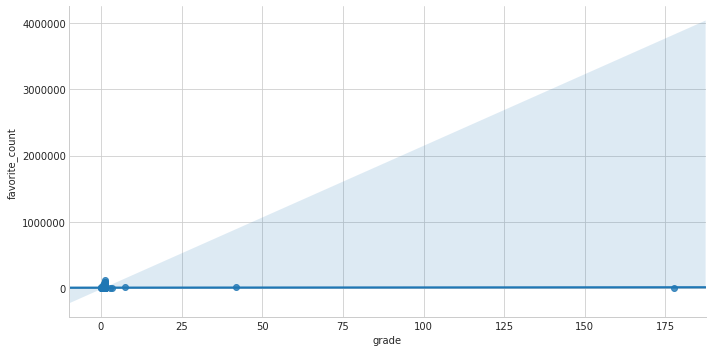

In [139]:
sns.lmplot('grade', 'favorite_count', data=df_master_clean, aspect=2, order=0.1)

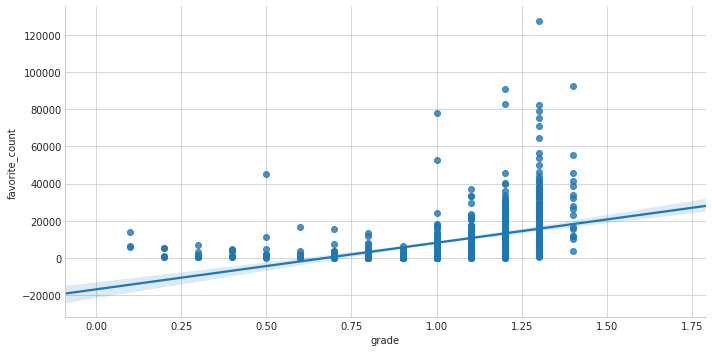

In [138]:
sns.lmplot('grade', 'favorite_count', data=df_master_clean.loc[df_master_clean.grade <2], aspect=2, order=0.1)

#### Retirando as notas muito altas podemos visualizar de forma clara que os tweets que possuem maiores notas tendem a ter mais favorite